#Deep Q-Network (Pong Problem)

1.Environment Preparation (OpenAI Gym)

In [8]:
!pip uninstall setuptools
!pip install setuptools==50.3.1
%conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [21]:
import torch
torch.cuda.is_available()


True

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [8]:
# 下載 ROM data 並解壓縮 (Windows)
! wget http://www.atarimania.com/roms/Roms.rar -OutFile ./Roms.rar
! mkdir ./ROM/
# [使用解壓縮軟體將 rar file 解壓縮到 ./ROM/]
! python -m atari_py.import_roms ./ROM/

copying adventure.bin from ./ROM/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to d:\anaconda3\envs\RL-39\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from ./ROM/Air Raid (1982) (Men-A-Vision) (PAL) ~.bin to d:\anaconda3\envs\RL-39\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from ./ROM/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to d:\anaconda3\envs\RL-39\lib\site-packages\atari_py\atari_roms\alien.bin
copying amidar.bin from ./ROM/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to d:\anaconda3\envs\RL-39\lib\site-packages\atari_py\atari_roms\amidar.bin
copying assault.bin from ./ROM/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to d:\anaconda3\envs\RL-39\lib\site-packages\atari_py\atari_roms\assault.bin
copying asterix.bin from ./ROM/Asterix (AKA Taz) (1984) (Atari, Jerome Domurat, Steve Woita) (CX2696).bin to d:\anaconda3\envs\RL-39\lib\si

In [ ]:
!pip install gym==0.19.0                    
# !pip install gym[atari]                     
%conda install -c conda-forge atari_py      
!pip install numpy
!pip install matplotlib

2.Pong Game and Wrapper

environment: PongNoFrameskip-v4
action space: 6
action: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space: (210, 160, 3)


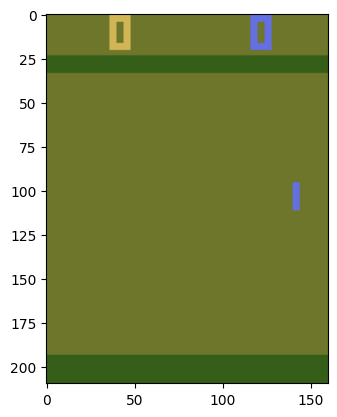

In [9]:
#Create PongNoFrameskip-v4 environment
import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env_name = "PongNoFrameskip-v4"
env = gym.make(env_name)

print("environment:", env_name)
print("action space:", env.action_space.n)
print("action:", env.unwrapped.get_action_meanings())
print("observation space:", env.observation_space.shape)
state = env.reset()
action = env.action_space.sample()
state_next, reward, done, info = env.step(action)
plt.figure()
plt.imshow(state_next)


In [10]:
# Environment wrapper
class PongEnvWrapper(gym.Wrapper):
  def __init__(self, env, k, img_size=(84,84)):
    gym.Wrapper.__init__(self, env)
    self.k = k
    self.img_size = img_size
    obs_shape = env.observation_space.shape
    self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(k, img_size[0],img_size[1]), dtype=np.float32)
  
  # Image preprocessing
  def _preprocess(self, state, th=0.4):
    state = np.array(Image.fromarray(state).resize(self.img_size, Image.BILINEAR))
    state = state.astype(np.float64).mean(2) / 255.
    state[state > th] = 1.0
    state[state <= th] = 0.0
    return state
  
  #Stack frames
  def reset(self):
    state = self.env.reset()
    state = self._preprocess(state)
    #Constrct initial stacked frame
    state = state[np.newaxis, ...].repeat(self.k, axis=0)
    return state

  # Construct stacked frames
  def step(self, action):
    state_next = []
    info = []
    reward = 0
    done = False
    for i in range(self.k):
      if not done:
        state_next_f, reward_f, done_f, info_f = self.env.step(action)
        state_next_f = self._preprocess(state_next_f)
        reward += reward_f
        done = done_f
        info.append(info_f)
      state_next.append(state_next_f[np.newaxis, ...])
    state_next = np.concatenate(state_next, 0)
    return state_next, reward, done, info

observation space: (4, 84, 84)
(4, 84, 84)


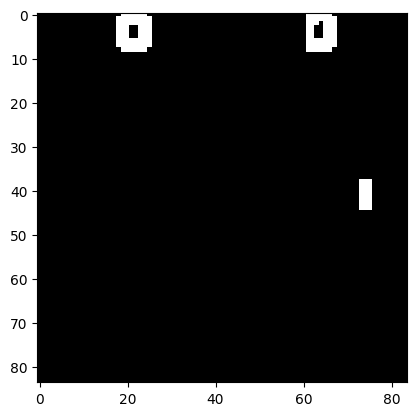

In [11]:
# Test Code
env_pong = PongEnvWrapper(env, k=4, img_size=(84,84))
print("observation space:", env_pong.observation_space.shape)

state = env_pong.reset()
action = env_pong.action_space.sample()
state_next, reward, done, info = env_pong.step(action)
print(state_next.shape)
plt.imshow(state_next[0], cmap="gray")

3.Reinforcement Learning

In [12]:
# CNN
class QNet(nn.Module):
  def __init__(self, input_shape, n_actions):
    super(QNet, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2),
      nn.ReLU(), 
      nn.Conv2d(64, 64, kernel_size=3, stride=1),
      nn.ReLU(), 
    )

    conv_out_size = self._get_conv_out(input_shape)

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(conv_out_size, 512),
        nn.ReLU(),
        nn.Linear(512, n_actions),
    )

  def _get_conv_out(self,shape):
    o = self.conv(torch.zeros(1, *shape))
    return int(np.prod(o.size()))

  def forward(self, x):
    conv_out = self.conv(x)
    out = self.fc(conv_out)
    return out

In [13]:
# Build DQN
class DeepQNetwork():
    def __init__(
        self,
        n_actions,
        input_shape,
        qnet,
        device,
        learning_rate = 2e-4,
        reward_decay = 0.99,
        replace_target_iter = 1000,
        memory_size = 10000,
        batch_size = 32,
    ):
        # initialize parameters
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.device = device
        self.learn_step_counter = 0
        self.init_memory()

        # Network
        self.qnet_eval = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target.eval()
        self.optimizer = optim.RMSprop(self.qnet_eval.parameters(), lr=self.lr)

    def choose_action(self, state, epsilon=0):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        actions_value = self.qnet_eval.forward(state)
        if np.random.uniform() > epsilon:   # epsilon-greedy
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()[0]
        else:   # random
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.qnet_target.load_state_dict(self.qnet_eval.state_dict())

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)

        b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
        b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
        b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
        b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
        b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)

        q_curr_eval = self.qnet_eval(b_s).gather(1, b_a)
        q_next_target = self.qnet_target(b_s_).detach()

        next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN

        q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values
        self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.learn_step_counter += 1
        return self.loss.detach().cpu().numpy()

    def init_memory(self):
        self.memory = {
            "s": np.zeros((self.memory_size, *self.input_shape)),
            "a": np.zeros((self.memory_size, 1)),
            "r": np.zeros((self.memory_size, 1)),
            "s_": np.zeros((self.memory_size, *self.input_shape)),
            "done": np.zeros((self.memory_size, 1)),
        }

    def store_transition(self, s, a, r, s_, d):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        if self.memory_counter <= self.memory_size:
            index = self.memory_counter % self.memory_size
        else:
            index = np.random.randint(self.memory_size)
        self.memory["s"][index] = s
        self.memory["a"][index] = np.array(a).reshape(-1,1)
        self.memory["r"][index] = np.array(r).reshape(-1,1)
        self.memory["s_"][index] = s_
        self.memory["done"][index] = np.array(d).reshape(-1,1)
        self.memory_counter += 1
    
    def save_load_model(self, op, path="save", fname="qnet.pt"):
        import os
        if not os.path.exists(path):
            os.makedirs(path)
        file_path = os.path.join(path, fname)
        if op == "save":
            torch.save(self.qnet_eval.state_dict(), file_path)
        elif op == "load":
            self.qnet_eval.load_state_dict(torch.load(file_path, map_location=self.device))
            self.qnet_target.load_state_dict(torch.load(file_path, map_location=self.device))
     

In [14]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
        n_actions = env.action_space.n,
        input_shape = [stack_frames, *img_size],
        qnet = QNet,
        device = device,
        learning_rate = 2e-4, 
        reward_decay = 0.99,
        replace_target_iter = 1000, 
        memory_size = 10000,
        batch_size = 32,)

print(agent.qnet_eval)

QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)


4.Training and testing

In [15]:
def play(env, agent, stack_frames, img_size):
    # Reset environment.
    state = env.reset()
    img_buffer = [Image.fromarray(state[0]*255)]

    # Initialize information.
    step = 0
    total_reward = 0

    # One episode.
    while True:
        # Select action.
        action = agent.choose_action(state, 0)

        # Get next stacked state.
        state_next, reward, done, info = env.step(action)
        if step % 2 == 0:
            img_buffer.append(Image.fromarray(state_next[0]*255))

        state = state_next.copy()
        step += 1
        total_reward += reward
        print('\rStep: {:3d} | Reward: {:.3f} / {:.3f}'\
            .format(step, reward, total_reward), end="")
            
        if done or step>2000:
            print()
            break

    return img_buffer

In [16]:
import os
def save_gif(img_buffer, fname, gif_path=os.path.join("/content/", "gif")):
    if not os.path.exists(gif_path):
        os.makedirs(gif_path)
    img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=1, loop=0)

In [17]:
# Test Code
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test.gif")

Step: 764 | Reward: -1.000 / -21.000


In [18]:
#epsilon-greedy compute
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.05, epsilon_decay=100000):
    return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

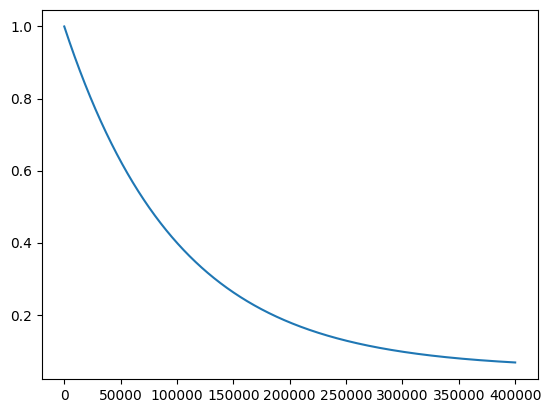

In [19]:
# Test Code
frame_ids = np.array(range(400000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)

In [20]:
# Start Training
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=1000000):
    total_step = 0
    episode = 0
    while True:
        # Reset environment.
        state = env.reset()

        # Initialize information.
        step = 0
        total_reward = 0
        loss = 0

        # One episode.
        while True:
            # Select action.
            epsilon = epsilon_compute(total_step)
            action = agent.choose_action(state, epsilon)

            # Get next stacked state.
            state_next, reward, done, info = env.step(action)

            # Store transition and learn.
            agent.store_transition(state, action, reward, state_next, done)
            if total_step > 4*agent.batch_size:
                loss = agent.learn()

            state = state_next.copy()
            step += 1
            total_step += 1
            total_reward += reward

            if total_step % 100 == 0 or done:
                print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
                    .format(episode, step, total_step, reward, total_reward, loss, epsilon), end="")
            
            if total_step % 10000 == 0:
                print("\nSave Model ...")
                agent.save_load_model(op="save", path=save_path, fname="qnet.pt")
                print("Generate GIF ...")
                img_buffer = play(env, agent, stack_frames, img_size)
                save_gif(img_buffer, "train_" + str(total_step).zfill(6) + ".gif")
                print("Done !!")

            if done or step>2000:
                episode += 1
                print()
                break
        
        if total_step > max_steps:
            break

In [23]:
train(env_pong, agent, stack_frames, img_size, save_path=os.path.join("/content/", "save"), max_steps=400000)

Episode:   0 | Step: 1013 / 1013 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.990
Episode:   1 | Step: 842 / 1855 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.983
Episode:   2 | Step: 976 / 2831 | Reward: -1.000 / -20.000 | Loss: 0.015 | Epsilon: 0.973
Episode:   3 | Step: 850 / 3681 | Reward: -1.000 / -21.000 | Loss: 0.001 | Epsilon: 0.966
Episode:   4 | Step: 944 / 4625 | Reward: -1.000 / -21.000 | Loss: 0.001 | Epsilon: 0.957
Episode:   5 | Step: 902 / 5527 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.949
Episode:   6 | Step: 824 / 6351 | Reward: -1.000 / -21.000 | Loss: 0.001 | Epsilon: 0.942
Episode:   7 | Step: 792 / 7143 | Reward: -1.000 / -21.000 | Loss: 0.002 | Epsilon: 0.935
Episode:   8 | Step: 838 / 7981 | Reward: -1.000 / -20.000 | Loss: 0.001 | Epsilon: 0.927
Episode:   9 | Step: 931 / 8912 | Reward: -1.000 / -20.000 | Loss: 0.001 | Epsilon: 0.919
Episode:  10 | Step: 849 / 9761 | Reward: -1.000 / -21.000 | Loss: 0.003 | Epsilon: 0.912
Episode: 

KeyboardInterrupt: 

In [24]:
# Evaluate the trained model
agent.save_load_model(op="load", path=os.path.join('/content', "save"), fname="qnet.pt")
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, "eval.gif")

Step: 1888 | Reward: 1.000 / 18.000


In [25]:
cnn = QNet([4,84,84],6)
print(cnn)

QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)
